In [1]:
import glob
import os
import pickle
import librosa
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

In [2]:
spl = 0

parent_dir = '../data/UrbanSound8K/audio/'
if spl:
    sub_dir = 'samples/'
else:
    sub_dir = 'train/'    
file_name = '*.wav'
train_files = glob.glob(os.path.join(parent_dir, sub_dir, file_name))
test_files = glob.glob(os.path.join(parent_dir, 'fold10/', file_name))

Kapre expect 2D array for audio.
<https://github.com/keunwoochoi/kapre/blob/master/examples/prepare%20audio.ipynb>

In [3]:
# def load_audio(files):
    
#     audio, labels = np.empty((0,1,4*22050)), np.empty(0)
#     for file in files:
#         labels = np.append(labels, file.split('\\')[1].split('-')[1])
#         x, sr = librosa.load(file)
#         x = np.pad(x,(0,88200-x.shape[0]),'constant')
#         x = x[:int(88200)]
#         x = x[np.newaxis, :]
#         audio = np.append(audio,x[None],axis=0)
#     return np.array(audio),np.array(labels, dtype=np.int)

def load_audio(files):
    
    features, labels = np.empty((0,128,173)), np.empty(0)
    i = 0
    for file in files:
        labels = np.append(labels, file.split('\\')[1].split('-')[1])
        x, sr = librosa.load(file)
        x = np.pad(x,(0,88200-x.shape[0]),'constant')
        
#         melspec = librosa.feature.melspectrogram(y=x, sr=sr)
#         melspec = librosa.power_to_db(melspec,ref=np.max)
#         features = np.append(features,melspec[None],axis=0)
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        features = np.append(features,mfccs[None],axis=0)
        
        i+=1
        if (i%50==0): 
            print(i)
    return np.array(features),np.array(labels, dtype=np.int)

In [19]:
def show_history(history):
    print(history.history.keys())
    fig = plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower left')
    plt.show()

## Preprocessing audio (Extract MFCC or Melspectrum)

In [6]:
train_data, train_labels = load_audio(train_files)
test_data, test_labels = load_audio(test_files)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


## Save features

In [7]:
# pickle.dump(train_data, open('./train_mfcc_features.dat', 'wb'))
# pickle.dump(train_labels, open('./train_mfcc_labels.dat', 'wb'))
# pickle.dump(test_data, open('./test_mfcc_features.dat', 'wb'))
# pickle.dump(test_labels, open('./test_mfcc_labels.dat', 'wb'))

# pickle.dump(train_data, open('./train_mel_features.dat', 'wb'))
# pickle.dump(train_labels, open('./train_mel_labels.dat', 'wb'))
# pickle.dump(test_data, open('./test_mel_features.dat', 'wb'))
# pickle.dump(test_labels, open('./test_mel_labels.dat', 'wb'))

## Load features

In [30]:
# train_data = pickle.load(open('./train_mfcc_features.dat', 'rb'))
# train_labels = pickle.load(open('./train_mfcc_labels.dat', 'rb'))
# test_data = pickle.load(open('./test_mfcc_features.dat', 'rb'))
# test_labels = pickle.load(open('./test_mfcc_labels.dat', 'rb'))

train_data = pickle.load(open('./train_mel_features.dat', 'rb'))
train_labels = pickle.load(open('./train_mel_labels.dat', 'rb'))
test_data = pickle.load(open('./test_mel_features.dat', 'rb'))
test_labels = pickle.load(open('./test_mel_labels.dat', 'rb'))

In [33]:
train_labels.shape

(2686, 10)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
keras.__version__

Using TensorFlow backend.


'2.2.0'

## Prepare train data

In [10]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [36]:
train_data.shape

(2686, 128)

In [35]:
train_data = np.mean(train_data, axis=2)
test_data = np.mean(test_data, axis=2)

In [ ]:
train_data = train_data+100
test_data = test_data+100
train_data = np.abs(train_data)
test_data = np.abs(test_data)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1],train_data.shape[2],1)
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1],test_data.shape[2],1)
# train_data = np.mean(train_data, axis=3)
# train_data = np.mean(train_data, axis=2)
# test_data = np.mean(test_data, axis=3)
# test_data = np.mean(test_data, axis=2)

In [ ]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu',input_shape = train_data.shape[1:]))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25)) 
model.add(Convolution2D(32, (3, 3),  activation='relu'))
model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.25))
# model.add(Convolution2D(32, (3, 3),  activation='relu'))
# model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary(line_length=80)

# cb = [LearningRateScheduler(lambda epoch: 0.0001 * 5 ** (epoch // 10))]

history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

In [ ]:
print(history.history.keys())

fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
model.predict(test_data[:10])

In [20]:
model2 = Sequential()
model2.add(Flatten(input_shape = train_data.shape[1:]))
model2.add(Dense(512, activation='relu'))
# model2.add(Dropout(0.5))
# model2.add(Dense(512, activation='relu'))
# model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))
adam = keras.optimizers.Adam(lr=0.002)
model2.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model2.summary(line_length=80)

history = model2.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_2 (Flatten)                 (None, 22144)                   0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 512)                     11338240    
________________________________________________________________________________
dense_6 (Dense)                     (None, 256)                     131328      
________________________________________________________________________________
dense_7 (Dense)                     (None, 10)                      2570        
Total params: 11,472,138
Trainable params: 11,472,138
Non-trainable params: 0
________________________________________________________________________________
Train on 2686 samples, validate on 837 samples
Epoch 1/10
2686/2686 [==============================] - 4s 2ms/st

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


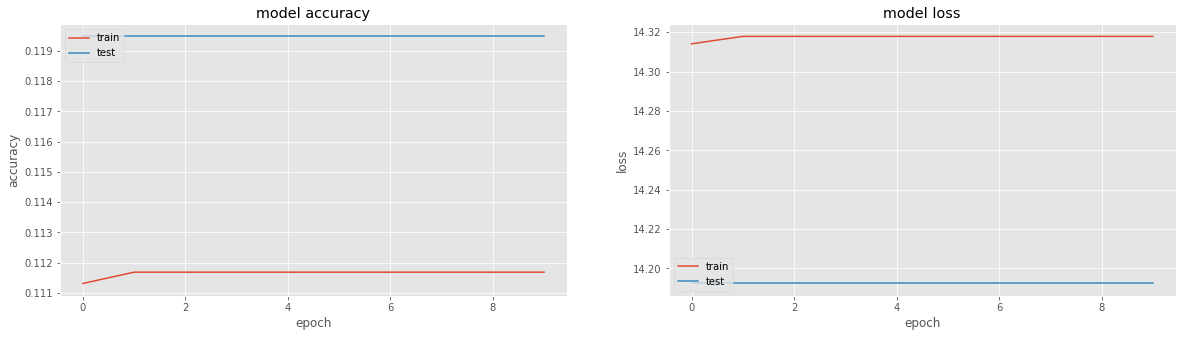

In [21]:
print(history.history.keys())

fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [23]:
model2.predict(test_data[:10])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

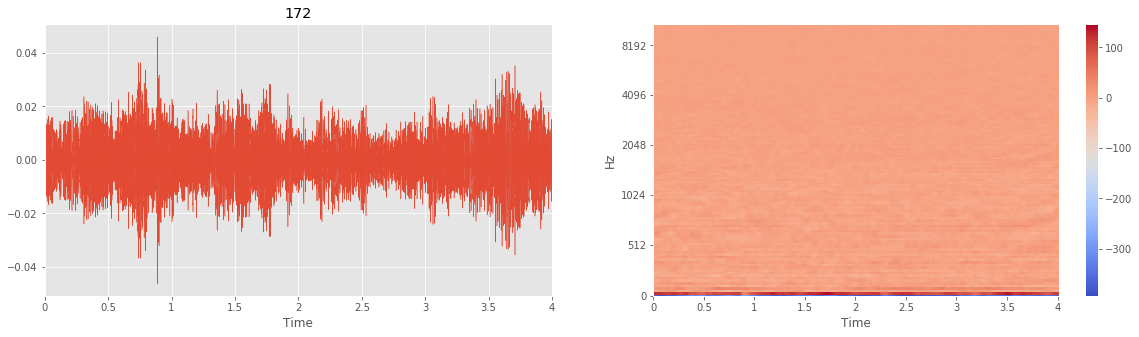

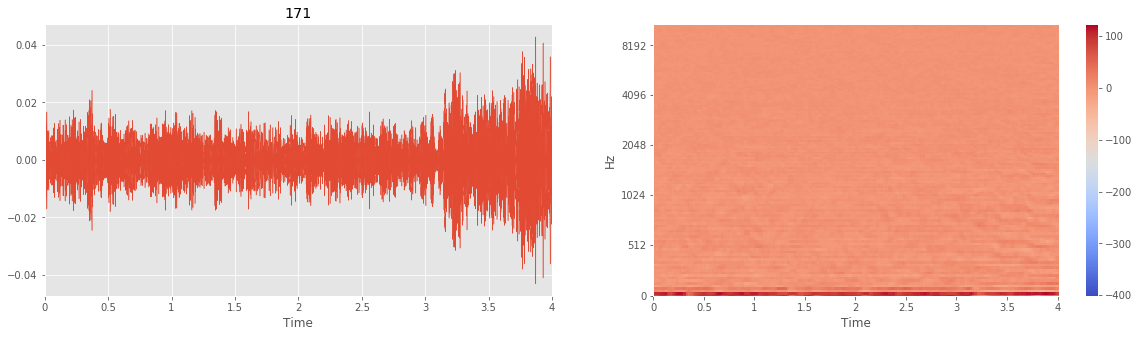

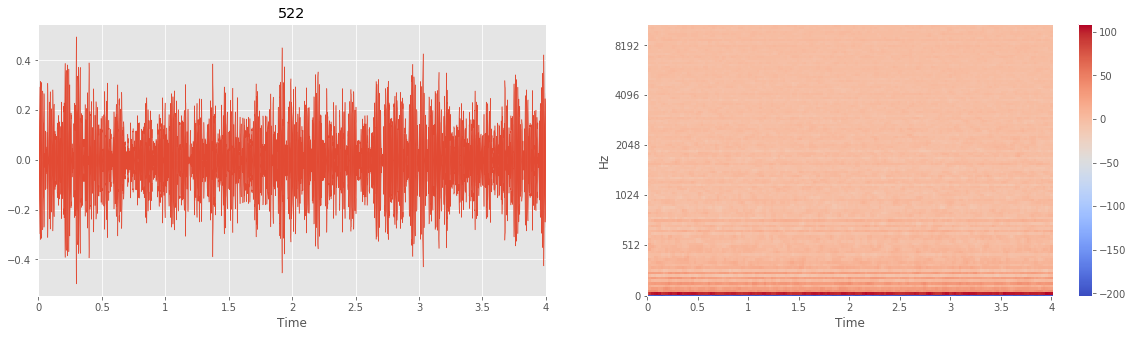

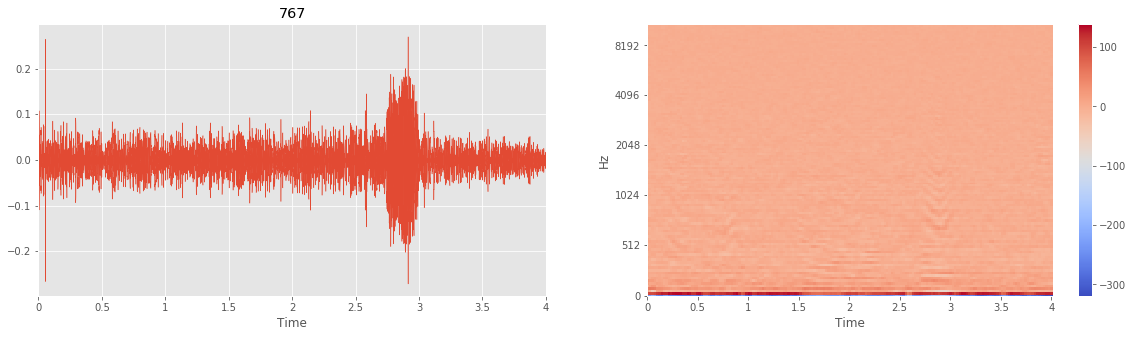

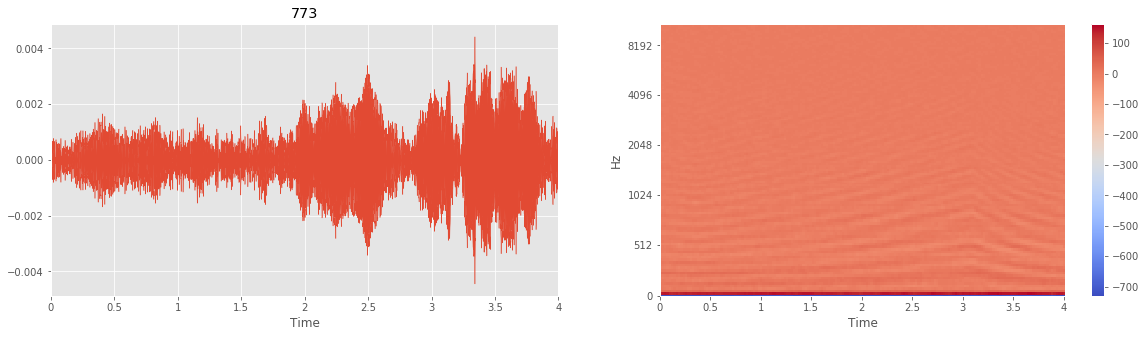

In [11]:
import librosa.display
for i in range(0,5):
    idx = np.random.randint(0,800)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    x, sr = librosa.load(train_files[idx])
    librosa.display.waveplot(x,sr=sr)
    mel = train_data[idx].reshape(128,173)
    plt.title(idx)
    plt.subplot(122)
    librosa.display.specshow(mel, x_axis='time', y_axis='mel')
    plt.colorbar()
plt.show()

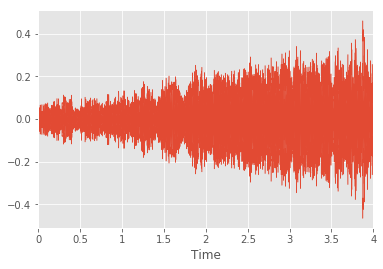

In [19]:
import IPython.display as ipd

idx = 289
x, sr = librosa.load(train_files[idx])
librosa.display.waveplot(x,sr=sr)
plt.show()
ipd.Audio(x, rate=sr)


In [ ]:
test_labels[:10]

In [ ]:
for file in test_files[:10]:
    print(file)

In [ ]:
model.predict(test_data[:10])

In [33]:
train_data = np.mean(train_data, axis=3)
train_data = np.mean(train_data, axis=2)
test_data = np.mean(test_data, axis=3)
test_data = np.mean(test_data, axis=2)

In [34]:
train_data.shape

(2686, 128)

In [37]:

model3 = Sequential()
model3.add(Dense(256,input_shape=train_data.shape[1:]))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(10))
model3.add(Activation('softmax'))

model3.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
__________

In [41]:
history = model3.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))


Train on 2686 samples, validate on 837 samples
Epoch 1/10
2686/2686 [==============================] - 0s 179us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 2/10
2686/2686 [==============================] - 0s 161us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 3/10
2686/2686 [==============================] - 0s 166us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 4/10
2686/2686 [==============================] - 0s 162us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 5/10
2686/2686 [==============================] - 0s 166us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 6/10
2686/2686 [==============================] - 0s 166us/step - loss: 13.9578 - acc: 0.1340 - val_loss: 14.2694 - val_acc: 0.1147
Epoch 7/10
2686/2686 [==============================] - 0s 166us/step - loss: 13.9580 - acc: 0.1340 - val_loss: 14.2694 - val

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


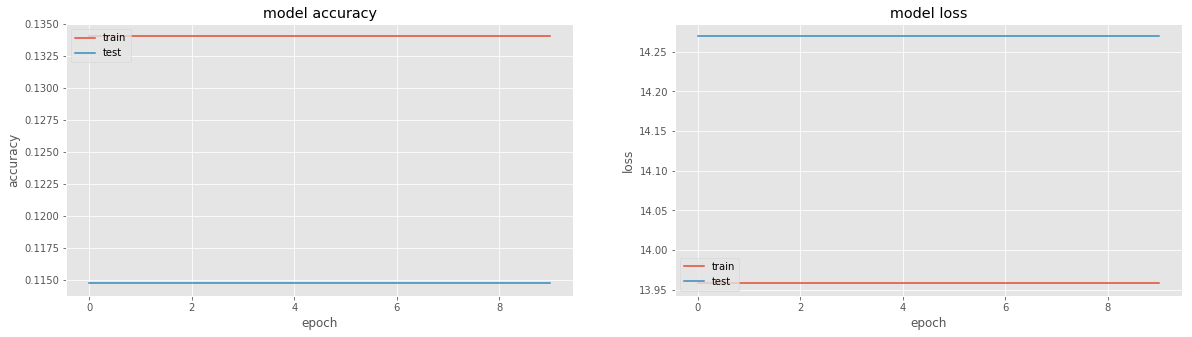

In [40]:
show_history(history)

In [ ]:
train_cnt = np.sum(test_labels, axis=0)

In [ ]:
train_cnt

In [23]:
import sklearn

In [27]:
train_data.shape

(2684, 128, 173)

In [29]:
train_data = sklearn.preprocessing.scale(train_data[:,], axis=2)

ValueError: Found array with dim 3. the scale function expected <= 2.